#Data Preparation:

Copyright part of each abstract aka. ending with © xxxxxxxx, is removed.



In [16]:
import os
import pandas as pd
import re

In [ ]:
# Initialize an empty list to store dictionaries
lst_dics = []

# Define the root path
root_path = ".../Abstract/"

# Iterate through each text file in the root path
for file_name in os.listdir(root_path):
    if file_name.endswith('.txt'):  # Process only text files
        file_path = os.path.join(root_path, file_name)

        # Read the file and process its content
        with open(file_path, 'r') as file:
            lines = file.readlines()

        # Extract category from the file name
        category = os.path.splitext(file_name)[0]  # File name without extension

        for line in lines:
            line = line.strip()
            if line.startswith("ABSTRACT:"):
                abstract = line.replace("ABSTRACT:", "").strip()
                # Remove copyright information
                clean_abstract = re.sub(r"\s*©.*$", "", abstract)
                if clean_abstract:
                    lst_dics.append({
                        "category": category,
                        "text": clean_abstract
                    })

# Create a DataFrame from the collected data
dtf = pd.DataFrame(lst_dics)

# Print the resulting DataFrame
print(dtf.head())

# Save the cleaned abstracts to a CSV file
dtf.to_csv("cleaned_abstracts.csv", index=False)

  category                                               text
0      owl  Leucocytozoon infection has been observed to i...
1      owl  Although the evolutionary ecology of melanin p...
2      owl  The California spotted owl (Strix occidentalis...
3      owl  Owls, members of the avian order Strigiformes,...
4      owl  Pest rodents cause extensive damage to crops w...


#Data Cleansing and Preprocessing:


In [ ]:

import nltk
from collections import Counter
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')



Remove default ntlk stop words like ('the', 'a' etc.)



> nltk.corpus.stopwords.words("english")



Remove top 10 frequency  words.

In [83]:


# Unified function for preprocessing text (WITHOUT filtering frequent words in the first run)
def preprocess_text_and_filter(text, category, lst_stopwords=None, additional_words=None, flg_stemm=False, flg_lemm=True, min_word_count=150):
    original_text = text  # Keep original for logging

    ## Clean (convert to lowercase and remove punctuations)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    ## Tokenize
    lst_text = text.split()

    ## Remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    ## Remove additional words (e.g., top frequent words for category)
    if additional_words is not None:
        lst_text = [word for word in lst_text if word not in additional_words]

    ## Check word count and filter out short rows
    if len(lst_text) < min_word_count:
        return None

    ## Stemming
    if flg_stemm:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    ## Lemmatization
    if flg_lemm:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]



    return " ".join(lst_text)

dtf["pcp_text_clean"] is the clean data after inital preprocessing.

In [84]:
# Step 1: Preprocess text WITHOUT removing frequent words yet
dtf["pcp_text_clean"] = dtf.apply(
    lambda row: preprocess_text_and_filter(
        row["text"],
        row["category"],
        lst_stopwords=nltk.corpus.stopwords.words("english"),
        additional_words=None,  # NO frequent word removal in this step
        flg_stemm=False,
        flg_lemm=True,
        min_word_count=150
    ), axis=1
)

# Drop rows where preprocessing returned None
dtf = dtf.dropna(subset=["pcp_text_clean"])

In [ ]:
# Step 2: Compute frequent words from the cleaned "pcp_text_clean"
def compute_top_frequent_words_per_category(dtf, top_n=10):
    category_frequent_words = {}
    for category in dtf["category"].unique():
        # Combine all processed text for the category
        text_for_category = " ".join(dtf[dtf["category"] == category]["pcp_text_clean"])
        # Tokenize the text
        tokens = text_for_category.split()
        # Compute word frequencies
        word_freq = Counter(tokens)
        # Get top N frequent words
        frequent_words = [word for word, freq in word_freq.most_common(top_n)]
        category_frequent_words[category] = frequent_words
        print(f"\nCategory: {category}, Top {top_n} frequent words: {frequent_words}")
    return category_frequent_words

# Compute frequent words AFTER preprocessing step 1
category_frequent_words = compute_top_frequent_words_per_category(dtf, top_n=10)

In [86]:


# Step 3: Preprocess AGAIN, this time removing frequent words
dtf["pcp_text_clean"] = dtf.apply(
    lambda row: preprocess_text_and_filter(
        row["pcp_text_clean"],  # Now we use the cleaned text
        row["category"],
        lst_stopwords=None,  # Stopwords already removed in Step 1
        additional_words=category_frequent_words.get(row["category"], []),  # NOW we remove frequent words
        flg_stemm=False,
        flg_lemm=True,
        min_word_count=150
    ), axis=1
)

# Drop rows where preprocessing returned empty results
dtf = dtf.dropna(subset=["pcp_text_clean"])



Split it into training (200 rows/category),  and testing datasets(50 rows/category)

In [87]:
import random
from sklearn.model_selection import train_test_split

# Function to select a random 100-word chunk
def select_random_chunk(text, chunk_size=100):
    words = text.split()
    if len(words) <= chunk_size:
        return text  # Return the text as is if it has fewer than 100 words
    start_idx = random.randint(0, len(words) - chunk_size)
    return " ".join(words[start_idx:start_idx + chunk_size])

# Apply random chunk selection to the cleaned text in dtf_limited
dtf_limited = dtf.groupby("category").head(250).reset_index(drop=True)  # Limit to first 250 rows/category
dtf_limited["pcp_text_clean"] = dtf_limited["pcp_text_clean"].apply(lambda x: select_random_chunk(x))

# Stratified split into training (80%) and testing (20%)
train_dtf, test_dtf = train_test_split(
    dtf_limited,
    test_size=0.2,  # 20% for testing
    stratify=dtf_limited["category"],  # Ensure stratified splitting
    random_state=42  # Reproducibility
)

# Save the split datasets
train_dtf.to_csv("training_dataset.csv", index=False)
test_dtf.to_csv("testing_dataset.csv", index=False)

# Print confirmation
print(f"Training dataset size: {train_dtf.shape[0]} rows")
print(f"Testing dataset size: {test_dtf.shape[0]} rows")


Training dataset size: 1000 rows
Testing dataset size: 250 rows


###Visualize Features of training dateset

In [88]:
from textblob import TextBlob
dtf["sentiment"] = train_dtf["pcp_text_clean"].apply(lambda x:
                   TextBlob(x).sentiment.polarity)
dtf.head()

,category,text,pcp_text_clean,sentiment
2,owl,The California spotted owl (Strix occidentalis...,california strix occidentalis occidentalis old...,NaN
3,owl,"Owls, members of the avian order Strigiformes,...",member avian order strigiformes nocturnal bird...,NaN
4,owl,Pest rodents cause extensive damage to crops w...,pest rodent cause extensive damage crop worldw...,0.013690
5,owl,Mitigating habitat loss of western burrowing o...,mitigating loss western burrowing athene cunic...,NaN
6,owl,Maintaining dense forest habitats for the thre...,maintaining dense threatened northern nso prov...,0.080093


In [89]:

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import FreqDist, ngrams
from wordcloud import WordCloud

Generated lst_words: ['analysis', 'level', 'two', 'used', 'using', 'found', 'higher', 'also', 'year', 'model', '95 ci', 'pan troglodyte', 'significantly higher', 'national park', 'significant difference', 'body condition', 'age class', 'tursiops truncatus', 'cortisol level', 'party size']


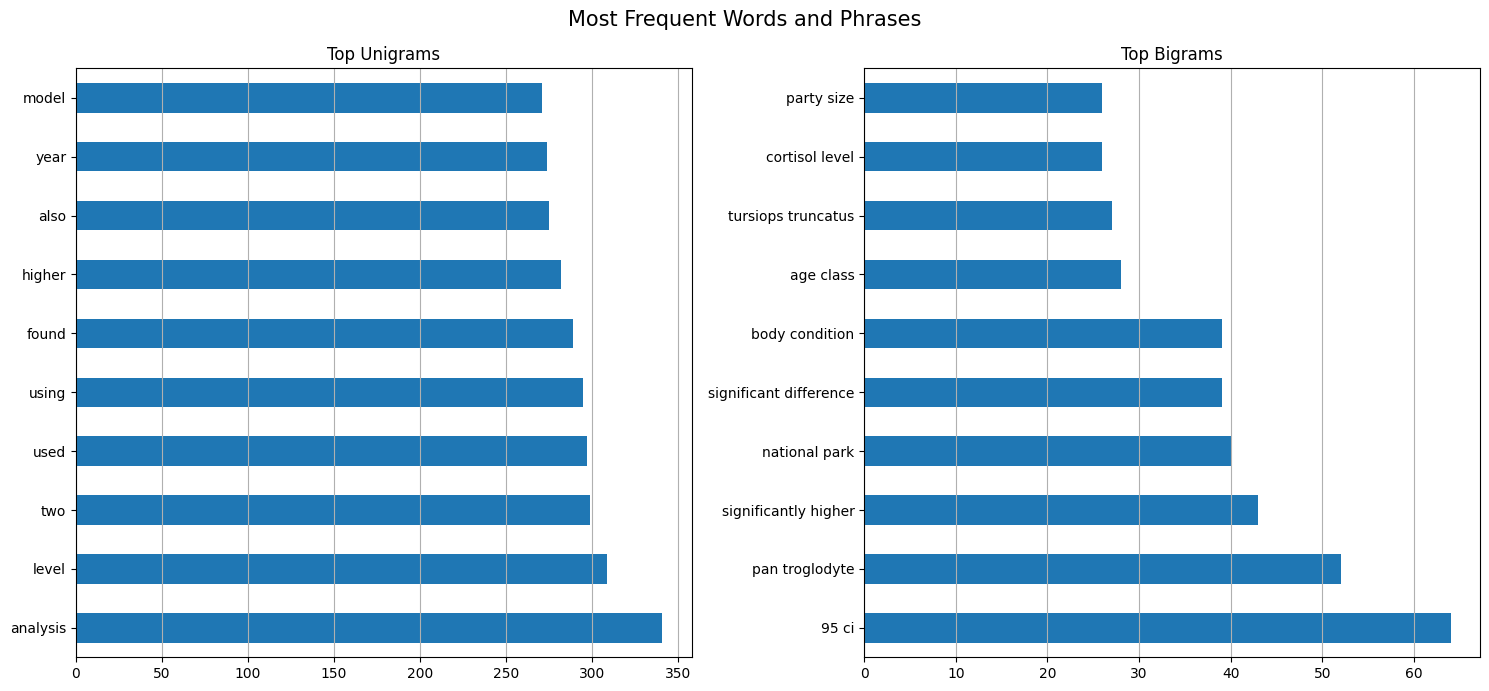

In [90]:
# Generate unigrams and bigrams from the training dataset
all_text = " ".join(train_dtf["pcp_text_clean"])
tokens = nltk.word_tokenize(all_text)

# Compute unigram and bigram frequencies
unigram_freq = FreqDist(tokens)
bigram_freq = FreqDist(ngrams(tokens, 2))

# Get the top 10 unigrams and bigrams
top_unigrams = [word for word, freq in unigram_freq.most_common(10)]
top_bigrams = [" ".join(bigram) for bigram, freq in bigram_freq.most_common(10)]

# Combine unigrams and bigrams
lst_words = top_unigrams + top_bigrams

# Print the generated lst_words
print("Generated lst_words:", lst_words)

# Vectorize the text in train_dtf using the generated lst_words
lst_grams = [len(word.split(" ")) for word in lst_words]
vectorizer = CountVectorizer(vocabulary=lst_words, ngram_range=(min(lst_grams), max(lst_grams)))
vectorized_features = pd.DataFrame(vectorizer.fit_transform(train_dtf["pcp_text_clean"]).todense(), columns=lst_words)

# Add the vectorized features to the training DataFrame
train_dtf = pd.concat([train_dtf.reset_index(drop=True), vectorized_features.reset_index(drop=True)], axis=1)

# Plot the frequency of unigrams and bigrams
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle("Most Frequent Words and Phrases", fontsize=15)

# Unigrams plot
unigram_df = pd.DataFrame(unigram_freq.most_common(10), columns=["Word", "Freq"])
unigram_df.set_index("Word").plot(kind="barh", ax=ax[0], title="Top Unigrams", legend=False)
ax[0].grid(axis='x')
ax[0].set_ylabel(None)

# Bigrams plot
bigram_df = pd.DataFrame(bigram_freq.most_common(10), columns=["Bigram", "Freq"])
bigram_df["Bigram"] = bigram_df["Bigram"].apply(lambda x: " ".join(x))
bigram_df.set_index("Bigram").plot(kind="barh", ax=ax[1], title="Top Bigrams", legend=False)
ax[1].grid(axis='x')
ax[1].set_ylabel(None)

plt.tight_layout()
plt.show()


when adding bigrams (tuples), the keys are not strings. Convert each bigram (tuple) into a string using " ".join(bigram).

Text(0.5, 1.0, 'Word Cloud of Top Unigrams and Bigrams')

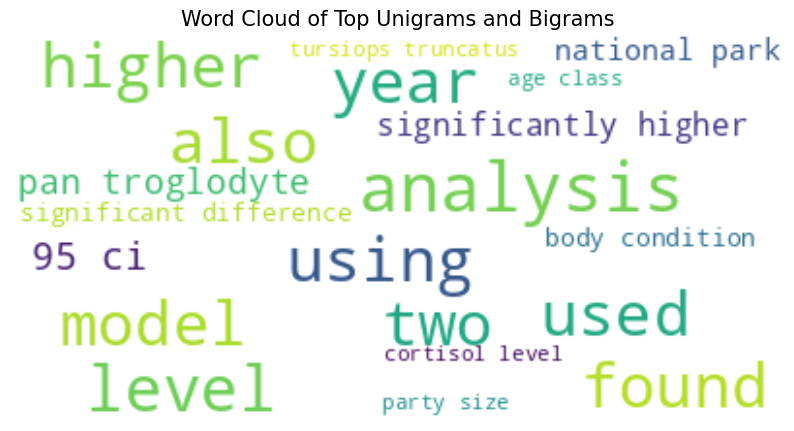

In [91]:


# Combine unigram and bigram frequencies into a single dictionary
combined_freq = {word: freq for word, freq in unigram_freq.most_common(10)}
combined_freq.update({" ".join(bigram): freq for bigram, freq in bigram_freq.most_common(10)})

# Generate the word cloud using the combined frequencies
from wordcloud import WordCloud

wc = WordCloud(background_color='white', max_words=100, max_font_size=35)
wc = wc.generate_from_frequencies(combined_freq)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.title("Word Cloud of Top Unigrams and Bigrams", fontsize=15)

##Predefine custom vectorizer

In [92]:

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score, classification_report
import gensim
from gensim.models import Word2Vec, Doc2Vec
import numpy as np

In [93]:
# Custom transformer for LDA
class LdaTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_topics=5, random_state=42):
        self.num_topics = num_topics
        self.random_state = random_state
        self.lda_model = None
        self.id2word = None

    def fit(self, X, y=None):
        # Tokenize the input text
        tokenized_docs = [doc.split() for doc in X]
        # Create a dictionary and corpus
        self.id2word = gensim.corpora.Dictionary(tokenized_docs)
        corpus = [self.id2word.doc2bow(doc) for doc in tokenized_docs]
        # Train LDA model
        self.lda_model = gensim.models.LdaModel(
            corpus=corpus,
            num_topics=self.num_topics,
            id2word=self.id2word,
            random_state=self.random_state,
            passes=10
        )
        return self

    def transform(self, X):
        # Tokenize the input text
        tokenized_docs = [doc.split() for doc in X]
        # Create a corpus
        corpus = [self.id2word.doc2bow(doc) for doc in tokenized_docs]
        # Get topic distribution for each document
        topic_distributions = [self.lda_model[doc] for doc in corpus]
        # Convert sparse topic distributions to dense format
        dense_topics = gensim.matutils.corpus2dense(topic_distributions, num_terms=self.num_topics).T
        return dense_topics

In [94]:
# Custom transformer for Word2Vec
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, X, y=None):
        tokenized_docs = [doc.split() for doc in X]
        self.model = gensim.models.Word2Vec(
            sentences=tokenized_docs,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers
        )
        return self

    def transform(self, X):
        tokenized_docs = [doc.split() for doc in X]
        # Average word vectors for each document
        vectors = []
        for doc in tokenized_docs:
            doc_vector = [self.model.wv[word] for word in doc if word in self.model.wv]
            if doc_vector:
                vectors.append(np.mean(doc_vector, axis=0))
            else:
                vectors.append(np.zeros(self.vector_size))
        return np.array(vectors)

# Custom transformer for Doc2Vec
class Doc2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=100, window=5, min_count=1, workers=4):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.workers = workers
        self.model = None

    def fit(self, X, y=None):
        tokenized_docs = [gensim.models.doc2vec.TaggedDocument(doc.split(), [i]) for i, doc in enumerate(X)]
        self.model = gensim.models.Doc2Vec(
            documents=tokenized_docs,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            workers=self.workers
        )
        return self

    def transform(self, X):
        tokenized_docs = [doc.split() for doc in X]
        vectors = [self.model.infer_vector(doc) for doc in tokenized_docs]
        return np.array(vectors)

##Training


Supports BOW, TF-IDF, n-grams, and LSI.
LDA, Word2Vec, and Doc2Vec require additional customization.

Models:

Supports SVM, Random Forest, Naïve Bayes, k-NN, XGBoost, and SGD.

Avoiding Data Leaks:

Vectorization, scaling are applied only on the training data within the pipeline.

GridSearchCV is used to optimize hyperparameters without leaking validation data.
Fine-Tuning:

Includes example parameter grids for SVM and SGD models.
Extensible to other models as needed.

Hidden Labels:

The target (y) is not exposed during preprocessing or model fitting, ensuring labels remain hidden.
Cross-Validation:


In [95]:
# Correct vectorizers dictionary
vectorizers = {
    "BOW": CountVectorizer(),
    "TFIDF": TfidfVectorizer(),
    "n-gram": CountVectorizer(ngram_range=(1, 2)),
    "LSI": Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svd', TruncatedSVD(n_components=100, random_state=42))
    ]),
    "LDA": Pipeline([
        ('lda', LdaTransformer(num_topics=5))
    ]),
    "Word2Vec": Word2VecTransformer(vector_size=100),
    "Doc2Vec": Doc2VecTransformer(vector_size=100)
}

models = {
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naïve Bayes": MultinomialNB(),
    "k-NN": KNeighborsClassifier(),
    "XGBoost": GradientBoostingClassifier(random_state=42),
    "SGD": SGDClassifier(random_state=42)
}

In [96]:
# Dictionary to store results for plotting later
results = {
    "Vectorizer": [],
    "Model": [],
    "Fold Accuracies": [],
    "Mean Accuracy": [],
    "Standard Deviation": [],
    "Predictions": [],  # Store predictions for later error analysis
    "True Labels": []   # Store true labels for later error analysis
}

In [97]:
# Data preparation
X = train_dtf["pcp_text_clean"]
y = train_dtf["category"]

In [98]:
# Cache for vectorized data to avoid recomputation
vectorized_data_cache = {}

# Function to train and evaluate a pipeline for each combination of vectorizer and model
def train_and_evaluate(vectorizer_name, model_name, vectorizer, model):
    print(f"Training pipeline: Vectorizer={vectorizer_name}, Model={model_name}")
    try:
        # Cache vectorized data
        if vectorizer_name not in vectorized_data_cache:
            vectorized_data_cache[vectorizer_name] = vectorizer.fit_transform(X)
        X_vectorized = vectorized_data_cache[vectorizer_name]

        # Create pipeline for model only (vectorization already done)
        pipeline = Pipeline([
            ('scaler', StandardScaler(with_mean=False)),  # Scaling step for applicable models
            ('classifier', model)
        ])

        # GridSearchCV for fine-tuning hyperparameters
        param_grid = {
            'classifier__C': [0.1, 1] if model_name == "SVM" else None,
            'classifier__alpha': [1e-3, 1e-2] if model_name == "SGD" else None
        }

        grid_search = GridSearchCV(
            pipeline,
            param_grid={k: v for k, v in param_grid.items() if v is not None},
            cv=5,  # Reduced cross-validation folds for speed
            scoring='accuracy',
            n_jobs=-1
        )

        # Fit GridSearchCV and evaluate
        grid_search.fit(X_vectorized, y)
        print(f"Best parameters for {vectorizer_name} + {model_name}: {grid_search.best_params_}")
        best_model = grid_search.best_estimator_

        # Cross-validation evaluation
        scores = cross_val_score(best_model, X_vectorized, y, cv=5, scoring='accuracy')
        mean_acc = scores.mean()
        std_acc = scores.std()

        # Print metrics
        print(f"Mean accuracy for {vectorizer_name} + {model_name}: {mean_acc:.4f}")
        print(f"Standard deviation: {std_acc:.4f}")

        # Store results
        results["Vectorizer"].append(vectorizer_name)
        results["Model"].append(model_name)
        results["Fold Accuracies"].append(scores.tolist())
        results["Mean Accuracy"].append(mean_acc)
        results["Standard Deviation"].append(std_acc)

        # Store predictions and true labels for error analysis
        y_pred = best_model.predict(X_vectorized)
        results["Predictions"].append(y_pred)
        results["True Labels"].append(y)

    except Exception as e:
        print(f"Error with Vectorizer={vectorizer_name}, Model={model_name}: {str(e)}")
        # Ensure results dictionary has placeholders to prevent KeyError
        results["Vectorizer"].append(vectorizer_name)
        results["Model"].append(model_name)
        results["Fold Accuracies"].append([])
        results["Mean Accuracy"].append(None)
        results["Standard Deviation"].append(None)
        results["Predictions"].append(None)
        results["True Labels"].append(None)


MultinomialNB is incompatible with vectorized data containing negative values. Combinations where MultinomialNB is paired with vectorizers that may produce negative values (Doc2Vec, Word2Vec, LSI, or LDA) may raise exception. This is expected.

In [ ]:
# Run initial evaluation to identify the champion model ~ 45min
for vectorizer_name, vectorizer in vectorizers.items():
    for model_name, model in models.items():
        if vectorizer is not None and not (model_name == "Naïve Bayes" and vectorizer_name in ["LSI", "LDA"]):
            train_and_evaluate(vectorizer_name, model_name, vectorizer, model)

##Champion Model Highlight:

Identifies the best-performing model-vectorizer combination and plot with Heatmap.

In [100]:
# Find the champion model
results_df = pd.DataFrame(results)
champion_index = results_df["Mean Accuracy"].idxmax()
champion_vectorizer = results_df.iloc[champion_index]["Vectorizer"]
champion_model = results_df.iloc[champion_index]["Model"]
print(f"Champion Model: {champion_vectorizer} + {champion_model}")

Champion Model: BOW + XGBoost


In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

Max Accuracy: 0.8110000000000002
Best Combinations: Index([4], dtype='int64')


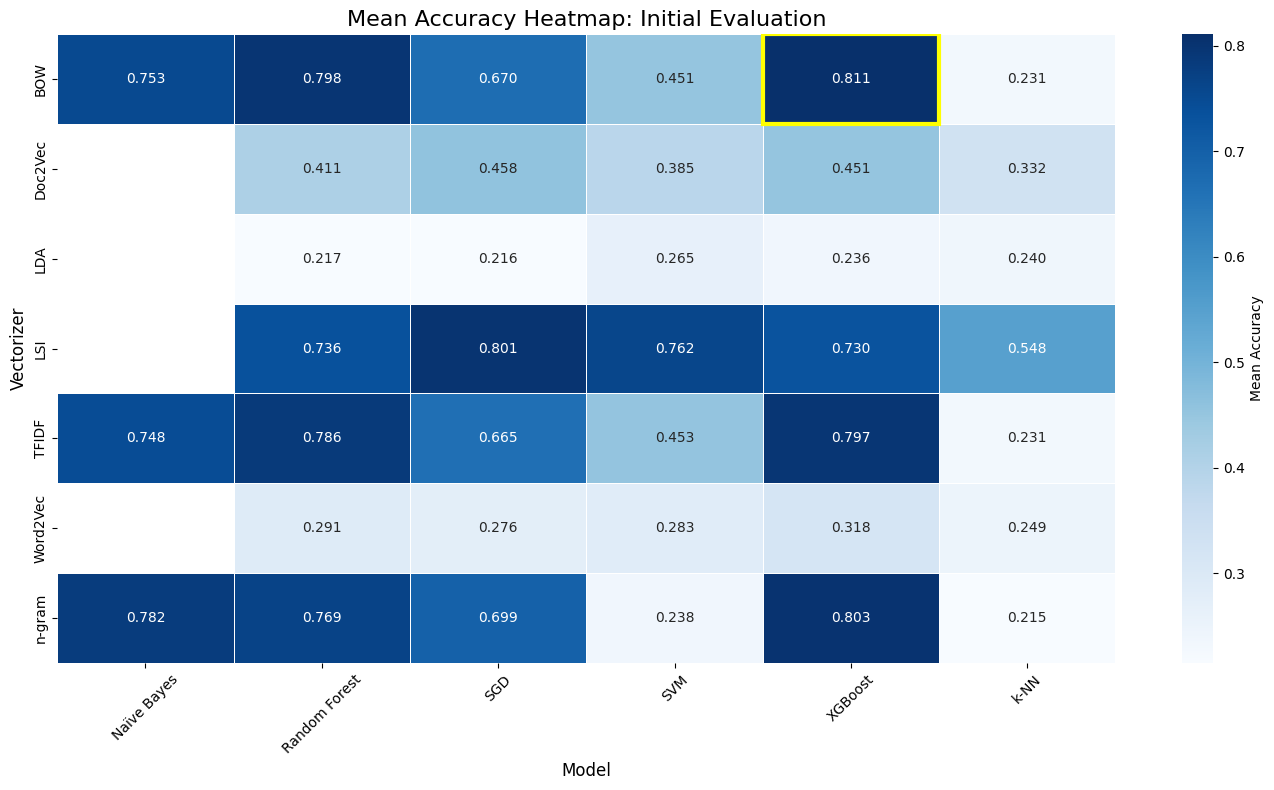

In [102]:
# Convert results into a pivot table for the heatmap
pivot_df = results_df.pivot(index="Vectorizer", columns="Model", values="Mean Accuracy")

# Identify all the best combinations (multiple ties if applicable)
max_accuracy = results_df["Mean Accuracy"].max()
print(f"Max Accuracy: {max_accuracy}")

best_indices = results_df[results_df["Mean Accuracy"] == max_accuracy].index

print(f"Best Combinations: {best_indices}")

# Plot the heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    linewidths=0.5,
    cbar_kws={'label': 'Mean Accuracy'},
    annot_kws={"fontsize": 10}
)

# Highlight all best combinations with yellow bounding boxes
for index in best_indices:
    best_vectorizer = results_df.iloc[index]["Vectorizer"]
    best_model = results_df.iloc[index]["Model"]
    best_row = pivot_df.index.get_loc(best_vectorizer)
    best_col = pivot_df.columns.get_loc(best_model)
    ax.add_patch(plt.Rectangle((best_col, best_row), 1, 1, fill=False, edgecolor='yellow', linewidth=3))

# Add labels and title
plt.title("Mean Accuracy Heatmap: Initial Evaluation", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Vectorizer", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()


#Evaluation:


In [103]:
# Perform cross-validation on the champion model only
X_vectorized = vectorized_data_cache[champion_vectorizer]
champion_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('classifier', models[champion_model])
])
champion_scores = cross_val_score(champion_pipeline, X_vectorized, y, cv=10, scoring='accuracy')

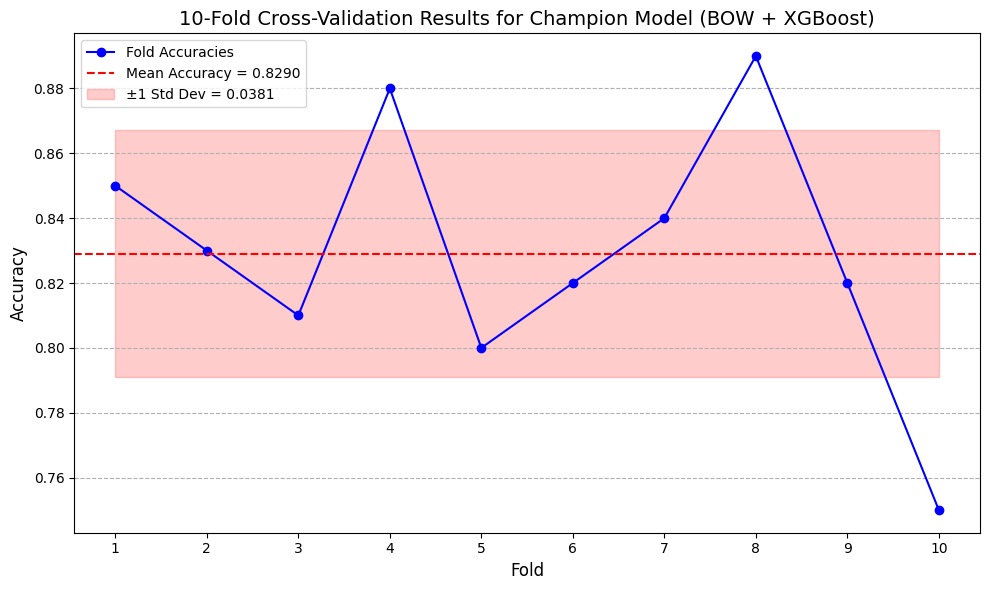

In [104]:


# Plot 10-fold cross-validation accuracies for the champion model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(champion_scores) + 1), champion_scores, marker='o', linestyle='-', color='blue', label="Fold Accuracies")
plt.axhline(y=champion_scores.mean(), color='red', linestyle='--', label=f"Mean Accuracy = {champion_scores.mean():.4f}")
plt.fill_between(
    range(1, len(champion_scores) + 1),
    [champion_scores.mean() - champion_scores.std()] * len(champion_scores),
    [champion_scores.mean() + champion_scores.std()] * len(champion_scores),
    color='red',
    alpha=0.2,
    label=f"±1 Std Dev = {champion_scores.std():.4f}"
)

# Add labels and title
plt.title(f"10-Fold Cross-Validation Results for Champion Model ({champion_vectorizer} + {champion_model})", fontsize=14)
plt.xlabel("Fold", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.xticks(range(1, len(champion_scores) + 1))
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--')

plt.tight_layout()
plt.show()

#Error Analysis


In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_val_predict

<Figure size 1000x700 with 0 Axes>

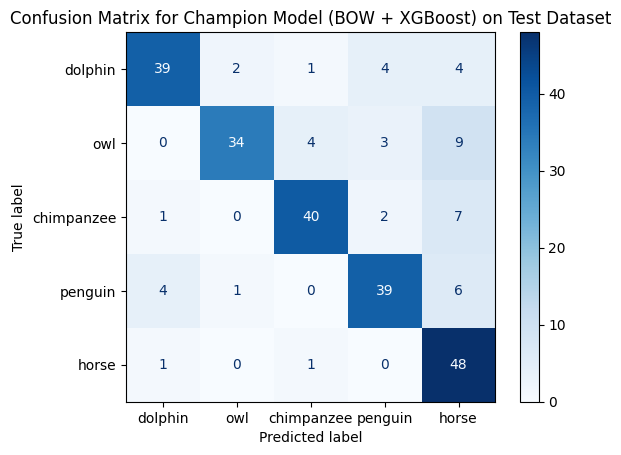


Classification Report:
              precision    recall  f1-score   support

     dolphin       0.87      0.80      0.83        50
         owl       0.87      0.78      0.82        50
  chimpanzee       0.65      0.96      0.77        50
     penguin       0.92      0.68      0.78        50
       horse       0.81      0.78      0.80        50

    accuracy                           0.80       250
   macro avg       0.82      0.80      0.80       250
weighted avg       0.82      0.80      0.80       250


Number of misclassified samples: 50

Examples of Misclassified Samples:
Text: performed generalized linear model relate green cover alan daily noise masking noise relation occurrence ie detected undetected also ran linear model assess relationship among beginning ending vocal activity alan anthropogenic masking noise level moment vocalization emitted finally explored variation vocal activity mottled measured vocalization rate across time result presence mottled increased size green

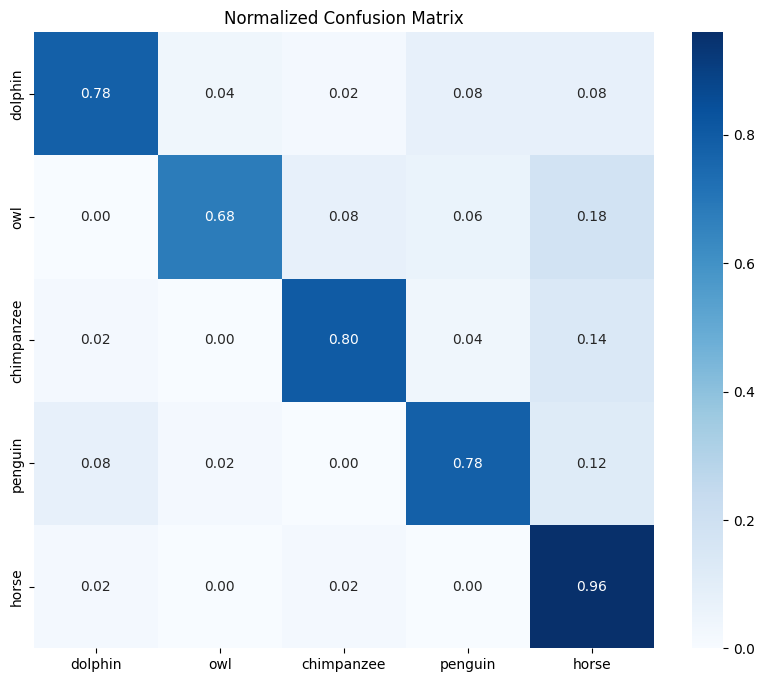


Training Accuracy: 1.0000
Test Accuracy: 0.8000
Model is overfitting.


In [106]:
# Generate predictions on the testing dataset
X_test = vectorizers[champion_vectorizer].transform(test_dtf["pcp_text_clean"])
y_test = test_dtf["category"]

# Fit the champion model on the training set
champion_pipeline.fit(X_vectorized, y)

# Generate predictions on the test dataset
y_pred_test = champion_pipeline.predict(X_test)

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test, labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_test.unique())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix for Champion Model ({champion_vectorizer} + {champion_model}) on Test Dataset")
plt.show()

# 2. Class-wise Performance Metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test, target_names=y_test.unique()))

# 3. Misclassified Samples
misclassified_indices = np.where(y_test != y_pred_test)[0]
print(f"\nNumber of misclassified samples: {len(misclassified_indices)}")
print("\nExamples of Misclassified Samples:")
for idx in misclassified_indices[:5]:  # Show first 5 misclassified samples
    print(f"Text: {test_dtf['pcp_text_clean'].iloc[idx]}")
    print(f"True Label: {y_test.iloc[idx]}")
    print(f"Predicted Label: {y_pred_test[idx]}")
    print("---")

# 4. Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=y_test.unique(), yticklabels=y_test.unique())
plt.title("Normalized Confusion Matrix")
plt.show()

# 5. Training Bias Detection
train_accuracy = champion_pipeline.score(X_vectorized, y)
test_accuracy = champion_pipeline.score(X_test, y_test)

# Print training and test accuracies
print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Detect bias
if train_accuracy > test_accuracy:
    print("Model is overfitting.")
elif train_accuracy < test_accuracy:
    print("Model is underfitting.")
else:
    print("Model has balanced training and test performance.")


##Will Deep learning model perform better?
Even tho BERT can convert punctuation into special tokens, to keep the data alignments, we still use preprocessed datasets:

train_dtf["pcp_text_clean"],
test_dtf["pcp_text_clean"]

In [107]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import torch
import os
os.environ["WANDB_DISABLED"] = "true"

Optimized BERT (Slim version):

*   Use Smaller Pre-trained Models (distilbert-base-uncased instead of bert-base-uncased)





In [ ]:
# Prepare data for BERT
train_texts = train_dtf["pcp_text_clean"].tolist()
train_labels = train_dtf["category"].tolist()

test_texts = test_dtf["pcp_text_clean"].tolist()
test_labels = test_dtf["category"].tolist()

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Tokenize data
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

# Prepare datasets for PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels_encoded)
test_dataset = CustomDataset(test_encodings, test_labels_encoded)

# Load DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert_results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./bert_logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True  # Enable mixed precision for faster training
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))
    }
)

# Train and evaluate
trainer.train()
bert_metrics = trainer.evaluate()

# Predictions and classification report
predictions = trainer.predict(test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
bert_accuracy = accuracy_score(test_labels_encoded, y_pred_bert)

print(f"\nBERT Test Accuracy: {bert_accuracy:.4f}")
print("\nBERT Classification Report:")
print(classification_report(test_labels_encoded, y_pred_bert, target_names=label_encoder.classes_))

# Store BERT evaluation results
results["Vectorizer"].append("BERT")
results["Model"].append("DistilBERT")
results["Fold Accuracies"].append(None)  # Not applicable for BERT
results["Mean Accuracy"].append(bert_accuracy)
results["Standard Deviation"].append(None)

In [ ]:
import csv

# Specify the output CSV file name
output_csv = "evaluation_results.csv"

# Open a file for writing
with open(output_csv, mode="w", newline="") as file:
    writer = csv.writer(file)

    # Write the header row (dictionary keys)
    writer.writerow(results.keys())

    # Transpose and write the rows (dictionary values)
    writer.writerows(zip(*results.values()))

print(f"Results have been exported to '{output_csv}'.")
